In [1]:
import time
import gc

import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt 
import seaborn as sns

from py.tap_trial import tap_trial
from py.central_node_selector import central_node_selector

This is written to be run on a **Linux** machine. First pass evaluations are done on the Sioux Falls network for speed and per standard.

# Examine runtime of different networks

Candidate networks need to have node coordinates and run relatively quickly.

In [2]:
networks = [
#     'berlin-center',
    'friedrichshain-center',
    'berlin-mitte-center',
    'berlin-mitte-prenzlauerberg-friedrichshain-center',
    'berlin-prenzlauerberg-center',
    'berlin-tiergarten',
#     'Birmingham',
#     'ChicagoSketch',
#     'Philadelphia',
    'SiouxFalls',
#     'ChicagoRegional'
]

tap_times = {}
for net in networks:
    print(net)
    start = time.time()
    try:
        tstt, _, _ = tap_trial('inputs/{}_net.tntp'.format(net), 'inputs/{}_trips.tntp'.format(net), norm_mean=1, norm_sd=0)
        if tstt == 0:
            print('TAP ISSUE with', net)
            tap_times[net] = np.nan
        else:
            tap_times[net] = time.time()-start
            print(tstt)
        print('')
        del tstt
    except OSError:
        print('MEMORY ISSUE with', net)
        tap_times[net] = np.nan
    gc.collect()
pd.Series(tap_times)

friedrichshain-center
728609.3041808965

berlin-mitte-center
1051175.4763035253

berlin-mitte-prenzlauerberg-friedrichshain-center
2362496.729620472

berlin-prenzlauerberg-center
1399925.4585168122

berlin-tiergarten
716823.6964993116

SiouxFalls
7480171.248174683



friedrichshain-center                                0.645014
berlin-mitte-center                                  0.923601
berlin-mitte-prenzlauerberg-friedrichshain-center    2.940272
berlin-prenzlauerberg-center                         0.905502
berlin-tiergarten                                    0.774335
SiouxFalls                                           0.109808
dtype: float64

# Analyze a specific network

## Scale iterations to match and find unperturbed ("true") network metrics.

In [3]:
net = 'SiouxFalls'
#     'friedrichshain-center'
#     'berlin-mitte-center'
#     'berlin-mitte-prenzlauerberg-friedrichshain-center'
#     'berlin-prenzlauerberg-center'
#     'berlin-tiergarten'
#     'SiouxFalls'

netFilename = 'inputs/{}_net.tntp'.format(net)
tripsFilename = 'inputs/{}_trips.tntp'.format(net)
    
n = 500
if tap_times[net] > 1:
    n = 100
elif tap_times[net] > .25:
    n = 200

true_df, true_tstt, true_wvc, true_vmt, true_demand, _ = tap_trial(netFilename,
                                                                   tripsFilename,
                                                                   norm_mean=1,
                                                                   norm_sd=0,
                                                                   returnDataFrame=True,
                                                                   returnODinfo=True)
print('True TSTT:', true_tstt)
print('      WVC:', true_wvc)
print('      VMT:', true_vmt)
print('   Demand:', true_demand)

true_costs = true_df['cost']
true_flows = true_df['flow']
# vc = true_df['flow']/true_df['capacity']
# true_most_congested_link_id = vc.idxmax()
# true_most_congested_link_vc = vc.max()
# del vc

# print('')
# print('Most congested link:', true_most_congested_link_id)
# print('           Link V/C:', true_most_congested_link_vc)

True TSTT: 7480171.248174683
      WVC: 1.4740301437798424
      VMT: 3419126.307475
   Demand: 360600.0


## Run trials for several perturbation mean and standard deviation combinations

(Except N(1,0) perturbations, since they only need one trial each.)

Avoid redoing the sampling by reading from a pre-exported csv. If it doesn't exist, then run the trials.

In [4]:
np.array([0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5])/.25

array([0.004, 0.02 , 0.04 , 0.08 , 0.2  , 0.4  , 0.8  , 2.   ])

In [5]:
def track_ci_width_evo(netFilename, tripsFilename, true_costs, true_flows, n=1000):#, true_most_congested_link_id, n=1000):
#     if n<=30:
#         raise ValueError('Sample size needs to be greater than 30.')
    
    means = np.array([1]) # np.arange(1.75, 0, -.25)
    sds = [0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5][::-1]

    results = {}

    for mean in means:
        results[mean] = {}
        for sd in sds:
            results[mean][sd] = {
                'tstts': np.zeros(n)*np.nan,
                'wvcs': np.zeros(n)*np.nan,
                'vmts': np.zeros(n)*np.nan,
                'costs_rmses': np.zeros(n)*np.nan,
                'cost_err25': np.zeros(n)*np.nan,
                'cost_err75': np.zeros(n)*np.nan,
                'flows_rmses': np.zeros(n)*np.nan,
                'flow_err25': np.zeros(n)*np.nan,
                'flow_err75': np.zeros(n)*np.nan,
#                 'most_congested_link_vcs': np.zeros(n)*np.nan,
#                 'tstt_widths': np.zeros(n)*np.nan,
#                 'wvc_widths': np.zeros(n)*np.nan,
#                 'vmt_widths': np.zeros(n)*np.nan,
#                 'flows_rmse_widths': np.zeros(n)*np.nan,
#                 'most_congested_link_vc_widths': np.zeros(n)*np.nan
            }
            r = results[mean][sd]
            for i in range(n):
                r['tstts'][i], r['wvcs'][i], r['vmts'][i], r['costs_rmses'][i], r['cost_err25'][i], r['cost_err75'][i], r['flows_rmses'][i], r['flow_err25'][i], r['flow_err75'][i] = tap_trial(
                    netFilename, tripsFilename, norm_mean=mean, norm_sd=sd,
                    true_costs=true_costs, true_flows=true_flows)#, focus_link=true_most_congested_link_id)
#                 ni = np.sqrt(i+1)
#                 results[mean][sd]['tstt_widths'][i] = 4*results[mean][sd]['tstts'][0:i+1].std()/ni
#                 results[mean][sd]['wvc_widths'][i] = 4*results[mean][sd]['wvcs'][0:i+1].std()/ni
#                 results[mean][sd]['vmt_widths'][i] = 4*results[mean][sd]['vmts'][0:i+1].std()/ni
#                 results[mean][sd]['flows_rmse_widths'][i] = 4*results[mean][sd]['flows_rmses'][0:i+1].std()/ni
#                 results[mean][sd]['most_congested_link_vc_widths'][i] = 4*results[mean][sd]['most_congested_link_vcs'][0:i+1].std()/ni
                if i>0 and results[mean][sd]['tstts'][i] > results[mean][sd]['tstts'][i-1]*1000:
                    raise ValueError('There may be a float/initialization error here.')
    
    # format the results into a DataFrame for easy querying and csv export
    df_trials = pd.DataFrame(columns=['mean', 'sd', 'tstt', 'wvc', 'vmt', 'costs_rmse', 'cost_err25', 'cost_err75', 'flows_rmse', 'flow_err25', 'flow_err75'])
#     df_ci_evo = pd.DataFrame(columns=['mean', 'sd', 'n', 'tstt_ci_width', 'congestion_ci_width', 'vmt_ci_width'])
    for mean in results:
        for sd in results[mean]:
            df_trials = pd.concat([df_trials, pd.DataFrame({
                'mean': np.ones(n)*mean,
                'sd': np.ones(n)*sd,
                'tstt': results[mean][sd]['tstts'],
                'wvc': results[mean][sd]['wvcs'],
                'vmt': results[mean][sd]['vmts'],
                'costs_rmse': results[mean][sd]['costs_rmses'],
                'cost_err25': results[mean][sd]['cost_err25'],
                'cost_err75': results[mean][sd]['cost_err75'],
                'flows_rmse': results[mean][sd]['flows_rmses'],
                'flow_err25': results[mean][sd]['flow_err25'],
                'flow_err75': results[mean][sd]['flow_err75'],
#                 'most_congested_link_vc': results[mean][sd]['most_congested_link_vcs']
            })], ignore_index=True, sort=False)
#             df_ci_evo = pd.concat([df_ci_evo, pd.DataFrame({
#                 'mean': np.ones(n)*mean,
#                 'sd': np.ones(n)*sd,
#                 'n': np.arange(1,n+1),
#                 'tstt_ci_width': results[mean][sd]['tstt_widths'],
#                 'congestion_ci_width': results[mean][sd]['wvc_widths'],
#                 'vmt_ci_width': results[mean][sd]['vmt_widths'],
#                 'flows_rmse_ci_width': results[mean][sd]['flows_rmse_widths'],
#                 'most_congested_link_vc_ci_width': results[mean][sd]['most_congested_link_vc_widths']
#             })], ignore_index=True, sort=False)
    df_trials.to_csv('output/data/{}_trials.csv'.format(net), index=False)
#     df_ci_evo.to_csv('output/data/{}_ci_evo.csv'.format(net), index=False)
    return df_trials#, df_ci_evo

try:
    # avoid redoing trials by reading from exports if they exist
    df_trials = pd.read_csv('output/data/{}_trials.csv'.format(net))
#     df_ci_evo = pd.read_csv('output/data/{}_ci_evo.csv'.format(net))
#     n = df_ci_evo['n'].max()+1
    n = df_trials[(df_trials['mean']==1) & (df_trials['sd']==0.1)].shape[0]
except FileNotFoundError:
    df_trials = track_ci_width_evo(netFilename, tripsFilename, true_costs, true_flows, n=n)
df_trials.head()

,mean,sd,tstt,wvc,vmt,costs_rmse,cost_err25,cost_err75,flows_rmse,flow_err25,flow_err75
0,1.0,0.5,7.188583e+06,1.454891,3.386991e+06,1.793009,-0.747304,0.333359,1245.525701,-754.643099,611.069795
1,1.0,0.5,7.008864e+06,1.438517,3.347382e+06,2.277803,-1.484768,0.221406,1553.510582,-1023.401674,517.422141
2,1.0,0.5,7.354342e+06,1.455456,3.381127e+06,1.481547,-0.870643,0.112251,978.445622,-759.886026,312.904665
3,1.0,0.5,6.804394e+06,1.429417,3.295416e+06,2.017559,-1.446902,0.004870,1288.414099,-1117.310915,143.474060
4,1.0,0.5,8.272373e+06,1.494986,3.519640e+06,2.166542,-0.500441,1.169936,1295.564747,-433.883377,1353.147350


## Compare results for different means

In [6]:
means = np.arange(0,2,.25)
reses = [tap_trial(netFilename, tripsFilename, norm_mean=mean, norm_sd=0,  
                   true_costs=true_costs, true_flows=true_flows, returnDataFrame=False) for mean in means]

# TODO: vmt, pc, most congested link analysis?
dfmeans = pd.DataFrame({
    'mean': means,
    'tstt': [r[0] for r in reses],
    'wvc': [r[1] for r in reses],
    'vmt': [r[2] for r in reses],
    'costs_rmse': [r[3] for r in reses],
    'cost_err25': [r[4] for r in reses],
    'cost_err75': [r[5] for r in reses],
    'flows_rmse': [r[6] for r in reses],
    'flow_err25': [r[7] for r in reses],
    'flow_err75': [r[8] for r in reses],
})
dfmeans.to_csv('output/data/{}_trials_means_only.csv'.format(net), index=False)
dfmeans.head(10)

,mean,tstt,wvc,vmt,costs_rmse,cost_err25,cost_err75,flows_rmse,flow_err25,flow_err75
0,0.00,0.000000e+00,0.000000,0.000000e+00,6.244605,-7.479121,-1.200594,12466.195912,-15292.871544,-8382.829875
1,0.25,8.277958e+05,0.514646,7.961663e+05,6.101839,-7.360098,-1.180327,9521.677677,-11911.621544,-5650.000000
2,0.50,1.870592e+06,0.829003,1.623629e+06,5.544822,-6.893024,-1.077085,6584.562265,-8262.457785,-3475.187360
3,0.75,3.654464e+06,1.145810,2.493965e+06,3.897694,-4.863088,-0.778839,3399.198727,-3942.319025,-1768.643446
4,1.00,7.480171e+06,1.474030,3.419126e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,1.25,1.567504e+07,1.790134,4.408337e+06,7.861444,1.164602,9.631130,3838.708583,1750.000000,4985.245509
6,1.50,3.286836e+07,2.129701,5.357056e+06,22.435459,4.676741,27.591739,7183.991432,3904.694325,8745.275521
7,1.75,6.554625e+07,2.479270,6.278202e+06,46.646506,9.232242,57.163937,10463.053891,5735.050706,12980.236887


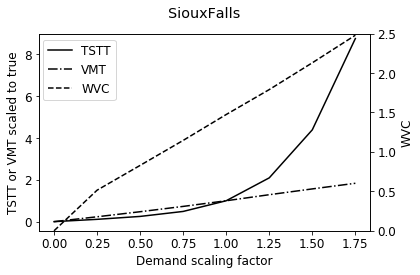

In [7]:
plt.rcParams.update({'font.size': 12})

def tstt_wvc_plot(df, input_key, input_name, net, log_input=False, log_tstt=False, tstt_top=None, wvc_top=None, output_fig_name=None):
    fig, ax1 = plt.subplots()
    ax1.set_xlabel(input_name)
    ax1.set_ylabel('TSTT or VMT scaled to true')
    ax1.plot(df[input_key], df['tstt']/(df.loc[df['mean']==1,'tstt'].values if input_key=='mean' else 1), c='k', label='TSTT')
    ax1.plot(df[input_key], df['vmt']/(df.loc[df['mean']==1,'vmt'].values if input_key=='mean' else 1), c='k', linestyle='-.', label='VMT')
    if log_input:
        ax1.set_xscale('log')
    if log_tstt:
        ax1.set_yscale('log')
    ax1.set_ylim(top=tstt_top)

    ax2 = ax1.twinx()
    ax2.set_ylabel('WVC')
    ax2.plot(df[input_key], df['wvc'], linestyle='--', c='k', label='WVC')
    ax2.set_ylim(bottom=0, top=wvc_top)

    fig.legend(loc=1, bbox_to_anchor=(0.25,1), bbox_transform=ax1.transAxes)
#     ax1.set_title('TSTT and congestion for varied {}\n[{}]'.format(input_name,net), y=1.05)
    ax1.set_title('{}'.format(net), y=1.05)
    fig.tight_layout()
    if output_fig_name:
        plt.savefig(output_fig_name, dpi='figure')
    plt.show()

tstt_wvc_plot(dfmeans, 'mean', 'Demand scaling factor', net, log_tstt=False,
              tstt_top=9, wvc_top=2.5,
              output_fig_name='output/plots/{}_mean_scaling.png'.format(net))

## Compare results for different standard deviations

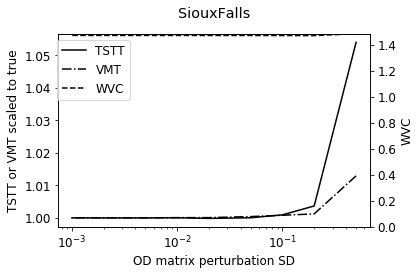

In [8]:
sds = df_trials['sd'].unique()
tstts_scaled = np.array([df_trials[(df_trials['mean']==1) & (df_trials['sd']==sd)]['tstt'].mean() for sd in sds])/true_tstt
congestions = np.array([df_trials[(df_trials['mean']==1) & (df_trials['sd']==sd)]['wvc'].mean() for sd in sds])
vmts_scaled = np.array([df_trials[(df_trials['mean']==1) & (df_trials['sd']==sd)]['vmt'].mean() for sd in sds])/true_vmt
# tstt_wvc_plot(sds[:-2], tstts_scaled[:-2], congestions[:-2], 'OD matrix perturbation SD', net, log_input=True, output_fig_name='output/plots/{}_stdv_scaling_clipped.png'.format(net))
tstt_wvc_plot(pd.DataFrame({
    'sd': sds,
    'tstt': tstts_scaled,
    'wvc': congestions,
    'vmt': vmts_scaled
}), 'sd', 'OD matrix perturbation SD', net, log_input=True, output_fig_name='output/plots/{}_stdv_scaling.png'.format(net))

## Visualize Monte Carlo trials

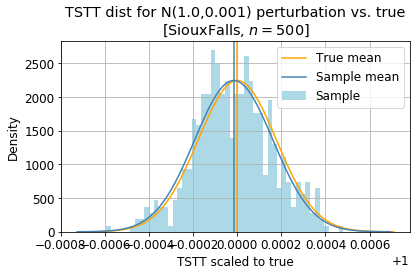

  true mean: 7480171.248174683
sample mean: 7480052.478109291
sample stdv: 1328.8163655396295
  shapiro p: 0.20807474851608276
% in 95% CI: 0.944



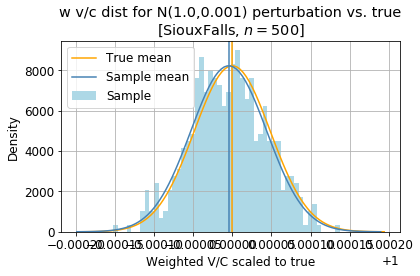

  true mean: 1.4740301437798424
sample mean: 1.4740235411137674
sample stdv: 7.156937657910632e-05
  shapiro p: 0.47453516721725464
% in 95% CI: 0.952


,mean,sd,tstt_mean,tstt_sd,tstt_p,wvc_mean,wvc_sd,wvc_p
0,1.0,0.001,7.480052e+06,1328.816366,0.208075,1.474024,0.000072,0.474535
1,1.0,0.005,7.479971e+06,6667.739101,0.282825,1.474010,0.000360,0.040673
2,1.0,0.010,7.480355e+06,13235.637989,0.937507,1.474018,0.000730,0.362552
3,1.0,0.020,7.478847e+06,26331.054793,0.562073,1.473865,0.001479,0.459469
4,1.0,0.050,7.480273e+06,65948.749634,0.273677,1.473665,0.003783,0.741436


In [9]:
def visualize(data, mean_true, plot_true_mean=True, xlabel='TSTT scaled to true', img_title=None, img_filename=None, verbose_output=False):
    mean_sample = data.mean()
    sd = data.std()
    plt.figure()
    
    mean_sample_normed = mean_sample/mean_true
    sd_normed = sd/mean_true
    xsnorm = np.linspace(mean_sample_normed - 4*sd_normed, mean_sample_normed + 4*sd_normed, 100)

    (data/mean_true).hist(bins=min([len(data)//10,100]), label='Sample', color='lightblue', density=True)
    if plot_true_mean:
        plt.axvline(x=1, color='orange')
        xtnorm = np.linspace(1 - 4*sd_normed, 1 + 4*sd_normed, 100)
        plt.plot(xtnorm, stats.norm.pdf(xtnorm, 1, sd_normed), color='orange', label='True mean')
    plt.axvline(x=mean_sample_normed, color='steelblue')
    plt.plot(xsnorm, stats.norm.pdf(xsnorm, mean_sample_normed, sd_normed), color='steelblue', label='Sample mean')
    
    if img_title:
        plt.title(img_title)
    plt.ylabel('Density')
    plt.xlabel(xlabel)
    plt.legend()
    plt.tight_layout()
    if img_filename:
        plt.savefig(img_filename, dpi='figure')
    
    if verbose_output:
        plt.show()
        print('  true mean:', mean_true)
        print('sample mean:', mean_sample)
        print('sample stdv:', sd)
    else:
        plt.close()
    
    return mean_sample, sd

def test_perturbation_pair(
    df,
    
    norm_mean,
    norm_sd,
    
    tstt_true,
    wvc_true,
    
    net_name=None,
    plot_true_mean=True,
    verbose_output=False
):
    
    dft = df.loc[np.isclose(df_trials['mean'],norm_mean) & np.isclose(df_trials['sd'],norm_sd)]
    n = len(dft)
    
    tstts = dft['tstt']
    tstt_mean, tstt_sd = visualize(tstts, tstt_true, plot_true_mean, 
                                   img_title='TSTT dist for N({},{}) perturbation vs. true\n[{}, $n={}$]'.format(norm_mean, norm_sd, net_name, n), 
                                   img_filename='output/plots/mcs/{}_tstt_N({},{})_n{}.png'.format(net_name, norm_mean, norm_sd, n), verbose_output=verbose_output)
    tstt_pvalue = stats.shapiro(tstts)[1]
    if verbose_output:
        print('  shapiro p:', tstt_pvalue)
        print('% in 95% CI:', ((tstts > tstt_mean-2*tstt_sd) & (tstts < tstt_mean+2*tstt_sd)).sum()/len(tstts))
        print('')
    
    wvcs = dft['wvc']
    wvc_mean, wvc_sd = visualize(wvcs, wvc_true, plot_true_mean, xlabel='Weighted V/C scaled to true',
                                 img_title='w v/c dist for N({},{}) perturbation vs. true\n[{}, $n={}$]'.format(norm_mean, norm_sd, net_name, n), 
                                 img_filename='output/plots/mcs/{}_wvc_N({},{})_n{}.png'.format(net_name, norm_mean, norm_sd, n), verbose_output=verbose_output)
    wvc_pvalue = stats.shapiro(wvcs)[1]
    if verbose_output:
        print('  shapiro p:', wvc_pvalue)
        print('% in 95% CI:', ((wvcs > wvc_mean-2*wvc_sd) & (wvcs < wvc_mean+2*wvc_sd)).sum()/len(wvcs))
    
    return tstt_mean, tstt_sd, tstt_pvalue, wvc_mean, wvc_sd, wvc_pvalue

def plot_all_pairs(df_trials, true_tstt, true_wvc, net):
    means = df_trials['mean'].unique()
    means.sort()
    sds = df_trials['sd'].unique()
    sds.sort()
    
    df_pairs = pd.DataFrame(columns=['mean', 'sd', 'tstt_mean', 'tstt_sd', 'tstt_p', 'wvc_mean', 'wvc_sd', 'wvc_p'])
    
    k=0
    for i,mean in enumerate(means):
        for sd in sds:
            tstt_mn, tstt_sd, tstt_p, wvc_mn, wvc_sd, wvc_p = test_perturbation_pair(df_trials,
                                                                                     mean, sd,
                                                                                     true_tstt, true_wvc,
                                                                                     net_name=net,
                                                                                     plot_true_mean=(mean==1),
                                                                                     verbose_output=(k==0))
            df_pairs.loc[k] = {
                'mean': mean,
                'sd': sd,
                'tstt_mean': tstt_mn,
                'tstt_sd': tstt_sd,
                'tstt_p': tstt_p,
                'wvc_mean': wvc_mn,
                'wvc_sd': wvc_sd,
                'wvc_p': wvc_p
            }
            k+=1
    
#     df_pairs.to_csv('output/data/{}_monte_carlo.csv'.format(net), index=False)
    
    return df_pairs

df_pairs = plot_all_pairs(df_trials, true_tstt, true_wvc, net)
df_pairs.head()

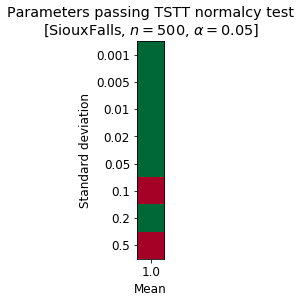

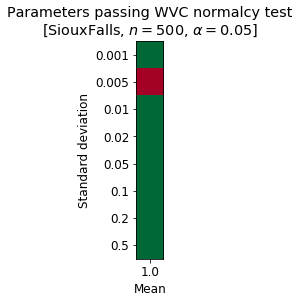

In [10]:
def normalcy_test_summary(df, match, alpha, net, n):
    means = df['mean'].unique()
    means.sort()
    sds = df_trials['sd'].unique()
    sds.sort()
    
    dat = np.zeros((len(sds), len(means)))
    
    for j,mean in enumerate(means):
        for i,sd in enumerate(sds):
            dat[i,j] = df.loc[(df['mean']==mean) & (df['sd']==sd), match.lower() + '_p'] > alpha
    plt.xticks(range(len(means)), labels=means)
    plt.yticks(range(len(sds)), labels=sds)
    plt.xlabel('Mean')
    plt.ylabel('Standard deviation')
    plt.title('Parameters passing {} normalcy test\n'.format(match)+r'[{}, $n={}$, $\alpha ={}$]'.format(net, n, alpha))
    if dat.all():
        plt.imshow(dat, cmap='ocean')
    else:
        plt.imshow(dat, cmap='RdYlGn')
    plt.savefig('output/plots/{}_normalcy_{}_a{}.png'.format(net, match.lower(), alpha), dpi='figure')
    plt.show()

normalcy_test_summary(df_pairs, 'TSTT', 0.05, net, n)
normalcy_test_summary(df_pairs, 'WVC', 0.05, net, n)

## Perturb a subset of nodes

How does TSTT change when we perturb only a subset of all nodes?

In [11]:
def partial_perturber(netFilename, tripsFilename, nodeFilename, proportion, true_costs, true_flows,
                      norm_mean=1, norm_sd=0, show_plot=False):
    '''
    Perturb <proportion> of zones closest to geographic center by Euclidean distance.
    Note that we perturb only zones (nodes with origin and destination flow), but that
    we measure by proportion of all nodes and only then filter for just zones.
    '''
    nodes_to_perturb = central_node_selector(nodeFilename, proportion, make_plot=show_plot, show_plot=show_plot)
    if show_plot:
        nodes_to_perturb = nodes_to_perturb[0]
    
    tstt = [None]*3
    congestion = [None]*3
    vmt = [None]*3
    costs_rmse = [None]*3
    cost_err25 = [None]*3 
    cost_err75 = [None]*3
    flows_rmses = [None]*3
    flow_err25 = [None]*3
    flow_err75 = [None]*3
    #most_congested_link_vc = [None]*3
    
    tstt[0], congestion[0], vmt[0], costs_rmse[0], cost_err25[0], cost_err75[0], flows_rmses[0], flow_err25[0], flow_err75[0] = tap_trial(
                                        netFilename, tripsFilename, norm_mean=norm_mean, norm_sd=norm_sd, returnDataFrame=False,
                                        nodesPerturbedIfOrig=nodes_to_perturb, true_costs=true_costs, true_flows=true_flows)
    tstt[1], congestion[1], vmt[1], costs_rmse[1], cost_err25[1], cost_err75[1], flows_rmses[1], flow_err25[1], flow_err75[1] = tap_trial(
                                        netFilename, tripsFilename, norm_mean=norm_mean, norm_sd=norm_sd, returnDataFrame=False,
                                        nodesPerturbedIfDest=nodes_to_perturb, true_costs=true_costs, true_flows=true_flows)
    tstt[2], congestion[2], vmt[2], costs_rmse[2], cost_err25[2], cost_err75[2], flows_rmses[2], flow_err25[2], flow_err75[2] = tap_trial(
                                        netFilename, tripsFilename, norm_mean=norm_mean, norm_sd=norm_sd, returnDataFrame=False,
                                        nodesPerturbedAlways=nodes_to_perturb, true_costs=true_costs, true_flows=true_flows)
    return tstt, congestion, vmt, costs_rmse, cost_err25, cost_err75, flows_rmses, flow_err25, flow_err75


def partial_perturber_sim(netFilename, tripsFilename, nodeFilename, net, true_costs, true_flows):
    
    df = pd.DataFrame(columns=['mean', 'p', 'method', 'tstt', 'wvc', 'vmt', 'costs_rmse',
                              'cost_err25', 'cost_err75', 'flows_rmses', 'flow_err25', 'flow_err75'])
    counter = 0
    
    means = np.arange(.5, 1.6, .25)
    means = means[means != 1]
    ps = np.arange(.25, 1.1, .25)
    methods = ['By origin', 'By destination', 'Both']
    
    for k,mean in enumerate(means):
        if mean==1:
            continue
        for p in ps:
            tstt, congestion, vmt, costs_rmse, cost_err25, cost_err75, flows_rmses, flow_err25, flow_err75 = partial_perturber(
                netFilename, tripsFilename, nodeFilename, p, true_costs, true_flows, norm_mean=mean, show_plot=(k==0))
            for i,method in enumerate(methods):
                df.loc[counter]={
                    'mean': mean,
                    'p': p,
                    'method': method,
                    'tstt': tstt[i],
                    'wvc': congestion[i],
                    'vmt': vmt[i],
                    'costs_rmse': costs_rmse[i],
                    'cost_err25': cost_err25[i],
                    'cost_err75': cost_err75[i],
                    'flows_rmse': flows_rmses[i],
                    'flow_err25': flow_err25[i],
                    'flow_err75': flow_err75[i]
                }
                counter += 1
    
    df.to_csv('output/data/{}_trials_partial_perturb.csv'.format(net), index=False)
    
    return df

nodeFilename = 'inputs/{}_node.tntp'.format(net)
try:
    df_partial = pd.read_csv('output/data/{}_trials_partial_perturb.csv'.format(net))
except FileNotFoundError:
    df_partial = partial_perturber_sim(netFilename, tripsFilename, nodeFilename, net, true_costs, true_flows)#, true_most_congested_link_id,)
df_partial.head()

,mean,p,method,tstt,wvc,vmt,costs_rmse,cost_err25,cost_err75,flows_rmses,flow_err25,flow_err75
0,0.5,0.25,By origin,4.429737e+06,1.228819,2.690839e+06,3.553178,-4.216486,-0.133485,NaN,-3074.739448,-696.865251
1,0.5,0.25,By destination,4.430935e+06,1.229201,2.689873e+06,3.560649,-4.241476,-0.126547,NaN,-3034.491615,-685.665704
2,0.5,0.25,Both,2.949053e+06,1.037014,2.201476e+06,4.593235,-6.014135,-0.671673,NaN,-5063.134254,-2102.847820
3,0.5,0.50,By origin,3.241227e+06,1.077114,2.309530e+06,4.481714,-5.509276,-0.198472,NaN,-4905.500750,-1639.048031
4,0.5,0.50,By destination,3.241529e+06,1.077144,2.309123e+06,4.485378,-5.594514,-0.203936,NaN,-4962.360305,-1649.373501


In [12]:
a = dfmeans[dfmeans['mean']==1].copy()
a.loc[:,'p'] = [1]
a

,mean,tstt,wvc,vmt,costs_rmse,cost_err25,cost_err75,flows_rmse,flow_err25,flow_err75,p
4,1.0,7.480171e+06,1.47403,3.419126e+06,0.0,0.0,0.0,0.0,0.0,0.0,1


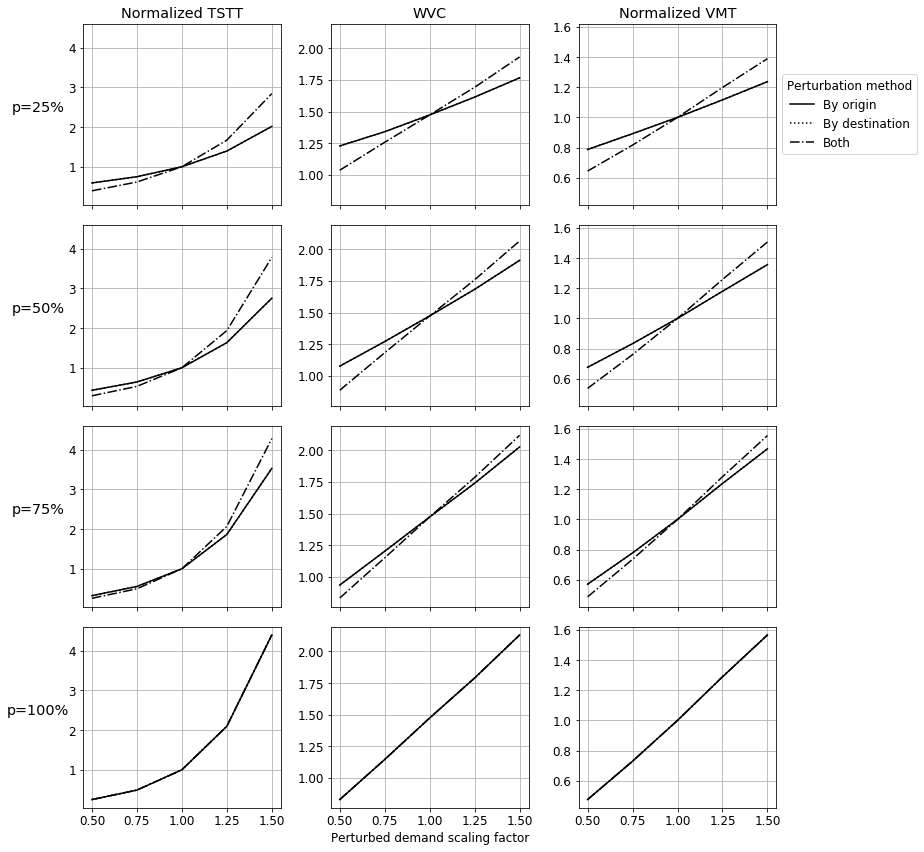

In [13]:
def partial_perturb_plotter(df, net, plotFilename=None):    
    means = np.append(df['mean'].unique(), 1)
    means.sort()
    ps = df['p'].unique()
    ps.sort()
    methods = df['method'].unique()
    methods.sort()
    methods = np.flip(methods)
    
    linestyles = ['-', ':', '-.']
    
    fig, axes = plt.subplots(nrows=len(ps), ncols=3, sharex=True, sharey='col', figsize=(13,len(ps)*3))
    
    axes[0][0].set_title('Normalized TSTT')
    axes[0][1].set_title('WVC')
    axes[0][2].set_title('Normalized VMT')
    for i,p in enumerate(ps):
        true_row = dfmeans[dfmeans['mean']==1].copy()
        true_row['p'] = p
        for j,method in enumerate(methods):
            true_row['method'] = method
            df = df.append(true_row, sort=False)
            df.sort_values('mean', inplace=True)
            axes[i][0].plot(means, df.loc[(df['p']==p) & (df['method']==method),'tstt']/true_tstt,
                                           linestyle=linestyles[j], c='k', label=method)
            axes[i][1].plot(means, df.loc[(df['p']==p) & (df['method']==method),'wvc'], linestyle=linestyles[j], c='k', label=method)
            axes[i][2].plot(means, df.loc[(df['p']==p) & (df['method']==method),'vmt']/true_vmt,
                                           linestyle=linestyles[j], c='k', label=method)
            axes[i][0].ticklabel_format(style='sci', scilimits=(0,0))
            axes[i][1].ticklabel_format(style='sci', scilimits=(0,0))
            axes[i][2].ticklabel_format(style='sci', scilimits=(0,0))
            axes[i][0].grid()
            axes[i][1].grid()
            axes[i][2].grid()
            axes[i][0].set_ylabel('p={:.0%}'.format(round(p,2)), rotation=0, size='large', labelpad=30)
    axes[0][2].legend(title='Perturbation method', loc='center left', bbox_to_anchor=(1,0.5))
    
#     fig.suptitle('Proportion of nodes perturbed vs. TSTT and weighted V/C\n[{}]'.format(net))
#     fig.text(0.5, 0.01, 'Perturbed demand scaling factor', ha='center', fontsize=14)
    axes[len(ps)-1,1].set_xlabel('Perturbed demand scaling factor')
    fig.tight_layout()
#     fig.subplots_adjust(bottom=0.05)
    if plotFilename:
        plt.savefig(plotFilename, dpi='figure')
    plt.show()

partial_perturb_plotter(df_partial, net, plotFilename='output/plots/{}_partial_perturb.png'.format(net))

### Sectional perturbation vs. global perturbation with matching demand

Suppose we perturb the 50% of nodes closest to the center of a net, then compare with an OD matrix that has been globally scaled to match the demand. How do the output metrics work out?

In [14]:
def progressive_partial_perturbation(netFilename, tripsFilename, nodeFilename, true_demand, net, verbose=False, saveplot=False):
    df = pd.DataFrame(columns=['mean', 'proportion', 'demand', 'tstt_partial', 'tstt_comp', 'wvc_partial', 'wvc_comp', 'vmt_partial', 'vmt_comp'])
    
    i = 0
    for m in np.arange(.25, 2, .25):
        for p in np.arange(.25, 1.1, .25):
            nodes_to_perturb = central_node_selector(nodeFilename, p, make_plot=False)
            # TODO: determine whether to incorporate VMT, % within 1%, most congested link if
            dfp, tsttp, wvcp, vmtp, demand, _ = tap_trial(netFilename, tripsFilename, norm_mean=m, 
                                                       norm_sd=0, returnDataFrame=True, returnODinfo=True, 
                                                       nodesPerturbedIfOrig=nodes_to_perturb)
            dfc, tsttc, wvcc, vmtc = tap_trial(netFilename, tripsFilename, norm_mean=demand/true_demand,
                                            norm_sd=0, returnDataFrame=True, returnODinfo=False)
            df.loc[i] = {
                'mean': m,
                'proportion': p,
                'demand': demand,
                'tstt_partial': tsttp,
                'tstt_comp': tsttc,
                'wvc_partial': wvcp,
                'wvc_comp': wvcc,
                'vmt_partial': vmtp,
                'vmt_comp': vmtc
            }
            i += 1
            
            if saveplot or i==1:
                ((dfp['flow']-dfc['flow'])/dfc['capacity']).hist(density=True)
                plt.title('Link-by-link difference in V/C between a {}x\npartial scaling and a commensurate global scaling\n[{}, p={}]'.format(m, net, p))
                plt.xlabel('V/C difference')
                plt.ylabel('Density of links')
                plt.grid(b=None)
                if saveplot:
                    plt.savefig('output/plots/{}_{}x_p{}.png'.format(net, m, p), dpi='figure')
                if verbose or i==1:
                    plt.show()
                else:
                    plt.close()
    df.to_csv('output/data/{}_ppp.csv'.format(net), index=False)
    
    return df

try:
    df_ppp = pd.read_csv('output/data/{}_ppp.csv'.format(net))
except FileNotFoundError:
    df_ppp = progressive_partial_perturbation(netFilename, tripsFilename, nodeFilename, true_demand, net, verbose=False, saveplot=False)
df_ppp.head()

,mean,proportion,demand,tstt_partial,tstt_comp,wvc_partial,wvc_comp,vmt_partial,vmt_comp
0,0.25,0.25,244650.0,3.639556e+06,2.997721e+06,1.138362,1.052570,2.350273e+06,2.243948e+06
1,0.25,0.50,183375.0,2.338017e+06,1.913946e+06,0.939877,0.839818,1.783363e+06,1.652788e+06
2,0.25,0.75,132450.0,1.411532e+06,1.265175e+06,0.697063,0.656492,1.268043e+06,1.181013e+06
3,0.25,1.00,90150.0,8.277958e+05,8.277958e+05,0.514646,0.514646,7.961663e+05,7.961663e+05
4,0.50,0.25,283300.0,4.429737e+06,4.052286e+06,1.228819,1.195250,2.690839e+06,2.617764e+06


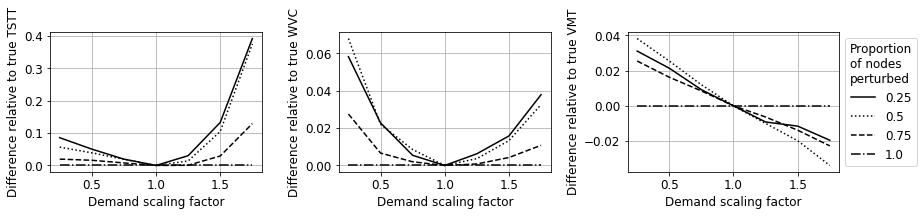

In [15]:
def ppp_plotter(df_ppp, net):
    fig, axes = plt.subplots(ncols=3, figsize=(13,3))
    props = df_ppp['proportion'].unique()
    props.sort()
    means = df_ppp['mean'].unique()
    means.sort()
    cm = plt.get_cmap('winter')
    linestyles = ['-', ':', '--', '-.']
    for i,p in enumerate(props):
        dftemp = df_ppp[df_ppp['proportion']==p].sort_values(by=['mean'])
        axes[0].plot(means, (dftemp['tstt_partial']-dftemp['tstt_comp'])/true_tstt, c='k', linestyle=linestyles[i], label=p)
        axes[1].plot(means, (dftemp['wvc_partial']-dftemp['wvc_comp'])/true_wvc, c='k', linestyle=linestyles[i], label=p)
        axes[2].plot(means, (dftemp['vmt_partial']-dftemp['vmt_comp'])/true_vmt, c='k', linestyle=linestyles[i], label=p)
    axes[0].set_ylabel('Difference relative to true TSTT')
    axes[0].set_xlabel('Demand scaling factor')
    axes[0].grid()
    axes[1].set_ylabel('Difference relative to true WVC')
    axes[1].set_xlabel('Demand scaling factor')
    axes[1].grid()
    axes[2].set_ylabel('Difference relative to true VMT')
    axes[2].set_xlabel('Demand scaling factor')
    axes[2].grid()
#     fig.suptitle('Difference between partial and global O-D matrix perturbation\n[{}]'.format(net))
    axes[2].legend(title='Proportion\nof nodes\nperturbed', loc='center left', bbox_to_anchor=(1, 0.5))
    fig.tight_layout()
#     fig.subplots_adjust(top=0.8)
    plt.savefig('output/plots/{}_partdiff.png'.format(net), dpi='figure')
    plt.show()

ppp_plotter(df_ppp, net)